In [1]:
import sys
import warnings
import math as m
import numpy as np
import pandas as pd
import tensorly as tl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import acf

import scipy
from scipy.linalg import hankel
from scipy.signal import find_peaks
from scipy.spatial import distance_matrix

import visuals
from visuals import SSA

In [2]:
plt.rcParams['font.family'] = 'DejaVu Serif'

In [3]:
def delay_embedding_matrix(s, nlags):
    """Make a matrix with delay embeddings.

    Parameters
    ----------
    s : np.array
        The time series data.

    nlags : int
        Size of time lags.

    Returns
    -------
    delay_embedding_matrix : np.array of shape  (len(s) - lags + 1 , lags)
        Matrix with lags.
    """ 
    N = len(s)
    delay_embedding_matrix = hankel(s[ : N - nlags + 1], s[N - nlags : N])
    return delay_embedding_matrix

In [4]:
def prepare_time_series(path, centred = True):
    data = pd.read_csv(path, delimiter =';', decimal=',')
    
    time_series = data[['X_value', 'Y_value', 'Z_value']]
    time_series[['x axis', 'y axis', 'z axis']] = time_series[['X_value', 'Y_value', 'Z_value']]
    time_series = time_series[['x axis', 'y axis', 'z axis']]
    if centred:
        time_series = (time_series - np.mean(time_series, axis = 0))/np.std(time_series, axis = 0)
        
    time_points = (data['time'].values).astype(float).reshape([-1,])
    time_points = np.linspace(0,time_points[-1]-time_points[0],time_series.shape[0])

    return time_series,time_points

In [5]:
path_basic_experiment = ['walk', 'stairs','bike', 'squats']
data_limits = [(7000,14000), (2300,7500), (14260,22548),  (4000,12000)]

In [6]:
index_activity = 0

CPU times: total: 625 ms
Wall time: 286 ms


C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


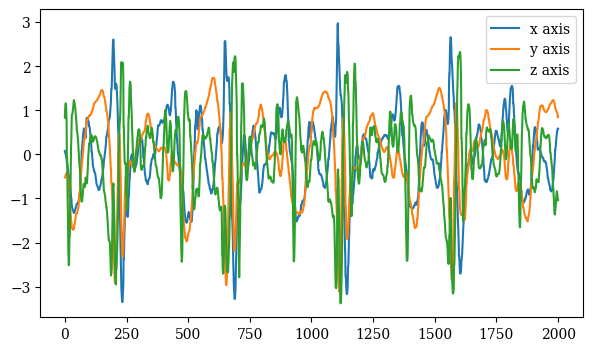

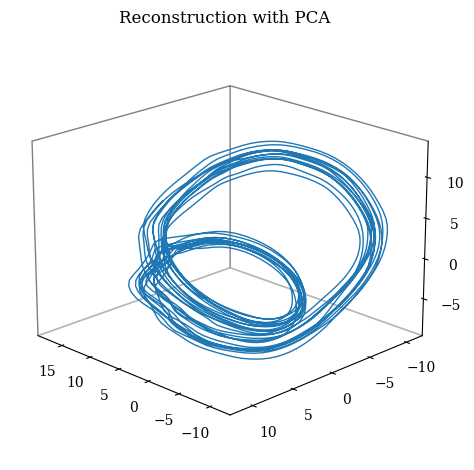

In [7]:
%%time
x_acc, t = prepare_time_series(f'./../data/basic_experiment_{path_basic_experiment[index_activity]}.csv', centred = True)
x_acc = x_acc[data_limits[index_activity][0]:data_limits[index_activity][1]:]
res = x_acc.reset_index(drop=True).loc[:2000].plot(figsize=(7,4)).get_figure()
res.savefig(f'./figs/init_time_series_{path_basic_experiment[index_activity]}.png')

S = np.array([
    delay_embedding_matrix(x_acc['x axis'].to_numpy(), 500),
    delay_embedding_matrix(x_acc['y axis'].to_numpy(), 500),
    delay_embedding_matrix(x_acc['z axis'].to_numpy(), 500)
])
# for i, s in enumerate(S):
#     visuals.plot_phase_trajectory(PCA(4).fit_transform(s)[::3,:3], path = f'./../slides/figs/phase_traj_{i}_PCA_{path_basic_experiment[index_activity]}.png')
s = delay_embedding_matrix((x_acc[['x axis','y axis','z axis']]**2).sum(axis=1)**0.5,500)

visuals.plot_phase_trajectory(PCA(4).fit_transform(s)[::3,:3], path=f'./figs/pca_{path_basic_experiment[index_activity]}.png', title="Reconstruction with PCA")

In [8]:
x_ssa = SSA(x_acc['x axis'].to_numpy(), 500).reconstruct(slice(0,10)).to_numpy()
y_ssa = SSA(x_acc['y axis'].to_numpy(), 500).reconstruct(slice(0,10)).to_numpy()
z_ssa = SSA(x_acc['z axis'].to_numpy(), 500).reconstruct(slice(0,10)).to_numpy()

C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


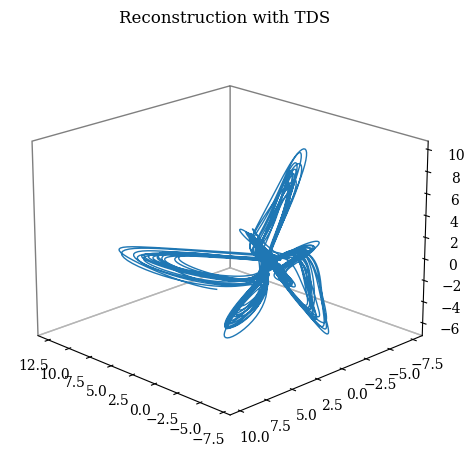

In [9]:
shape_dims = [6, 3]
S = np.array([
    delay_embedding_matrix(x_ssa, shape_dims[0]*60)[:,::60],
    delay_embedding_matrix(y_ssa, shape_dims[0]*60)[:,::60],
    delay_embedding_matrix(z_ssa, shape_dims[0]*60)[:,::60]
    
])
################################################
## Make a subspace #############################
X_p = [tl.tenalg.outer([S[n,i,:] for n in range(S.shape[0])]).reshape(-1,) for i in range(S.shape[1])]
    
X_p = np.array(X_p)
visuals.plot_phase_trajectory(
    PCA(3).fit_transform(X_p)[:],
    path=f'./figs/tds_{path_basic_experiment[index_activity]}.png',
    rotation = (0,0,0),
    title = "Reconstruction with TDS"
) 

In [10]:
index_activity = 1

C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


CPU times: total: 1min 31s
Wall time: 52.9 s


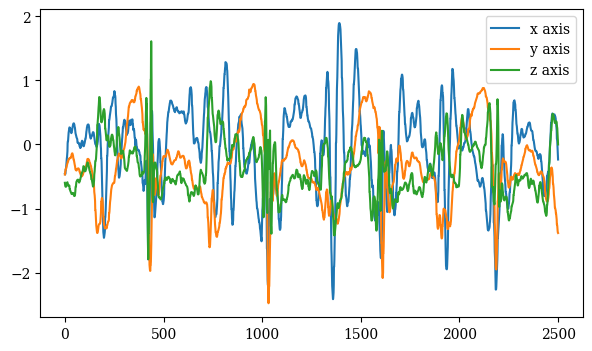

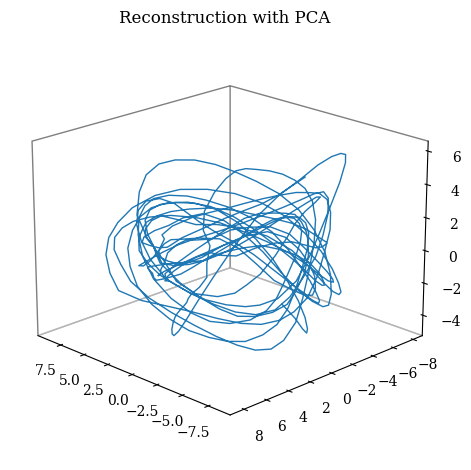

In [11]:
%%time
x_acc, t = prepare_time_series(f'./../data/basic_experiment_{path_basic_experiment[index_activity]}.csv', centred = True)
x_acc = x_acc[data_limits[index_activity][0]:data_limits[index_activity][1]:]
res = x_acc.reset_index(drop=True).loc[:2500].plot(figsize=(7,4)).get_figure()
res.savefig(f'./../slides/figs/init_time_series_{path_basic_experiment[index_activity]}.png')


S = np.array([
    delay_embedding_matrix(x_acc['x axis'].to_numpy(), 500),
    delay_embedding_matrix(x_acc['y axis'].to_numpy(), 500),
    delay_embedding_matrix(x_acc['z axis'].to_numpy(), 500)
])
# for i, s in enumerate(S):
#     visuals.plot_phase_trajectory(PCA(4).fit_transform(s)[::3,:3], path = f'./../slides/figs/phase_traj_{i}_PCA_{path_basic_experiment[index_activity]}.png')
s = delay_embedding_matrix((x_acc[['x axis','y axis','z axis']]**2).sum(axis=1)**0.5,500)
visuals.plot_phase_trajectory(PCA(4).fit_transform(s)[::10,:3], path=f'./figs/pca_{path_basic_experiment[index_activity]}.png', title="Reconstruction with PCA")


x_ssa = SSA(x_acc['x axis'].to_numpy(), 500).reconstruct(slice(0,10)).to_numpy()
y_ssa = SSA(x_acc['y axis'].to_numpy(), 500).reconstruct(slice(0,10)).to_numpy()
z_ssa = SSA(x_acc['z axis'].to_numpy(), 500).reconstruct(slice(0,10)).to_numpy()

C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


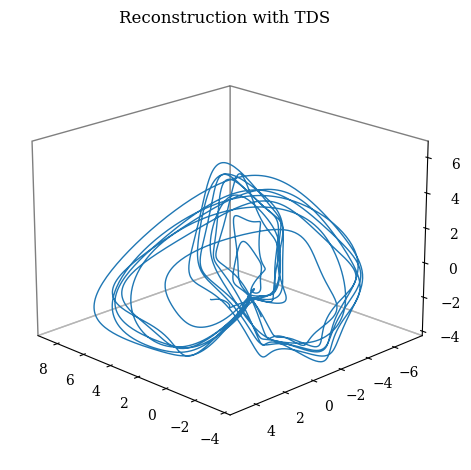

In [12]:
shape_dims = [15, 3]
S = np.array([
    delay_embedding_matrix(x_ssa, shape_dims[0]*50)[:,::50],
    delay_embedding_matrix(y_ssa, shape_dims[0]*50)[:,::50],
    delay_embedding_matrix(z_ssa, shape_dims[0]*50)[:,::50]
])
################################################
## Make a subspace #############################
X_p = []
for i in range(S.shape[1]):
    X_p.append(tl.tenalg.outer([S[n,i,:] for n in range(S.shape[0])]).reshape(-1,))
    
X_p = np.array(X_p)
visuals.plot_phase_trajectory(
    PCA(3).fit_transform(X_p)[:],
    path=f'./figs/tds_{path_basic_experiment[index_activity]}.png',
    rotation = (0,40,0),
    title = "Reconstruction with TDS"
) 

In [13]:
index_activity = 2

C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


CPU times: total: 2min 35s
Wall time: 45.7 s


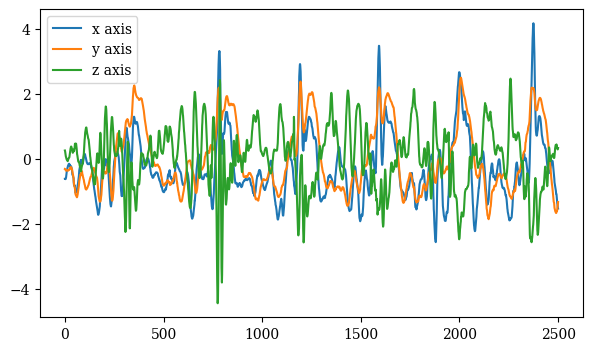

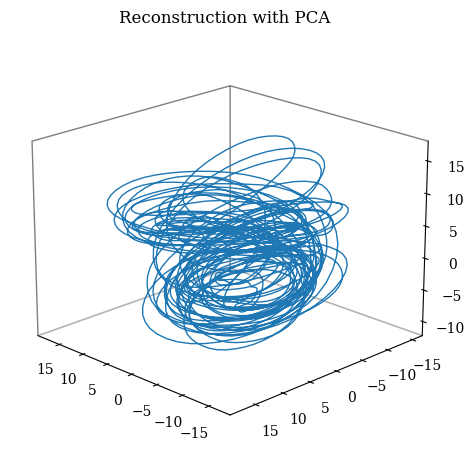

In [14]:
%%time
x_acc, t = prepare_time_series(f'./../data/basic_experiment_{path_basic_experiment[index_activity]}.csv', centred = True)
x_acc = x_acc[data_limits[index_activity][0]:data_limits[index_activity][1]:]
res = x_acc.reset_index(drop=True).loc[:2500].plot(figsize=(7,4)).get_figure()
res.savefig(f'./figs/init_time_series_{path_basic_experiment[index_activity]}.png')


S = np.array([
    delay_embedding_matrix(x_acc['x axis'].to_numpy(), 500),
    delay_embedding_matrix(x_acc['y axis'].to_numpy(), 500),
    delay_embedding_matrix(x_acc['z axis'].to_numpy(), 500)
])
# for i, s in enumerate(S):
#     visuals.plot_phase_trajectory(PCA(4).fit_transform(s)[::3,:3], path = f'./../slides/figs/phase_traj_{i}_PCA_{path_basic_experiment[index_activity]}.png')
s = delay_embedding_matrix((x_acc[['x axis','y axis','z axis']]**2).sum(axis=1)**0.5,500)
visuals.plot_phase_trajectory(PCA(4).fit_transform(s)[::3,:3], path=f'./figs/pca_{path_basic_experiment[index_activity]}.png', title="Reconstruction with PCA")


x_ssa = SSA(x_acc['x axis'].to_numpy(), 300).reconstruct(slice(0,10)).to_numpy()
y_ssa = SSA(x_acc['y axis'].to_numpy(), 300).reconstruct(slice(0,10)).to_numpy()
z_ssa = SSA(x_acc['z axis'].to_numpy(), 300).reconstruct(slice(0,10)).to_numpy()
shape_dims = [7, 3]
# S = np.array([
#     delay_embedding_matrix(x_acc['X_value'].to_numpy(), 500)[:,::50],
#     delay_embedding_matrix(x_acc['Y_value'].to_numpy(), 500)[:,::50],
#     delay_embedding_matrix(x_acc['Z_value'].to_numpy(), 500)[:,::50]
# ])

C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


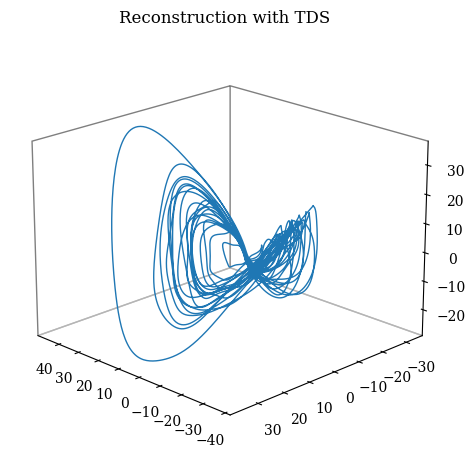

In [15]:
shape_dims = [10, 3]
S = np.array([
    delay_embedding_matrix(x_ssa, shape_dims[0]*30)[:,::30],
    delay_embedding_matrix(y_ssa, shape_dims[0]*30)[:,::30],
    delay_embedding_matrix(z_ssa, shape_dims[0]*30)[:,::30]
])
################################################
## Make a subspace #############################
X_p = []
for i in range(S.shape[1]):
    X_p.append(tl.tenalg.outer([S[n,i,:] for n in range(S.shape[0])]).reshape(-1,))
    
X_p = np.array(X_p)
visuals.plot_phase_trajectory(
    PCA(3).fit_transform(X_p)[:],
    path=f'./figs/tds_{path_basic_experiment[index_activity]}.png',
    rotation = (0,-60,0),
    title = "Reconstruction with TDS"
) 

In [16]:
index_activity = 3

C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


CPU times: total: 2min 21s
Wall time: 47.7 s


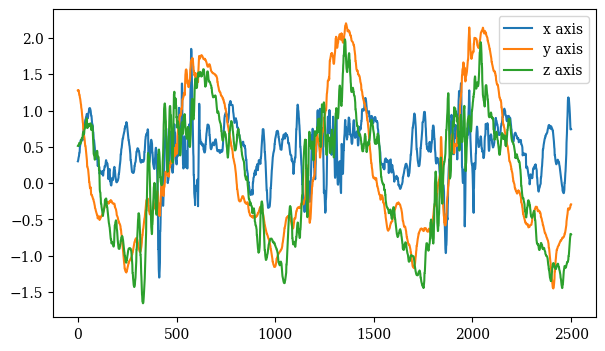

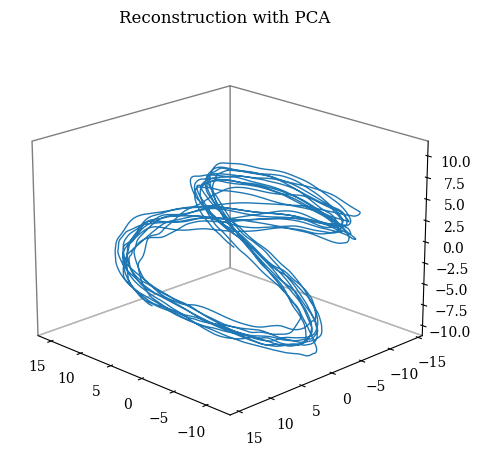

In [17]:
%%time
x_acc, t = prepare_time_series(f'./../data/basic_experiment_{path_basic_experiment[index_activity]}.csv', centred = True)
x_acc = x_acc[data_limits[index_activity][0]:data_limits[index_activity][1]:]
res = x_acc.reset_index(drop=True).loc[:2500].plot(figsize=(7,4)).get_figure()
res.savefig(f'./figs/init_time_series_{path_basic_experiment[index_activity]}.png')


S = np.array([
    delay_embedding_matrix(x_acc['x axis'].to_numpy(), 500),
    delay_embedding_matrix(x_acc['y axis'].to_numpy(), 500),
    delay_embedding_matrix(x_acc['z axis'].to_numpy(), 500)
])
# for i, s in enumerate(S):
#     visuals.plot_phase_trajectory(PCA(4).fit_transform(s)[::3,:3], path = f'./../slides/figs/phase_traj_{i}_PCA_{path_basic_experiment[index_activity]}.png')
s = delay_embedding_matrix((x_acc[['x axis','y axis','z axis']]**2).sum(axis=1)**0.5,500)
visuals.plot_phase_trajectory(PCA(4).fit_transform(s)[::3,:3], path=f'./figs/pca_{path_basic_experiment[index_activity]}.png', title="Reconstruction with PCA")


x_ssa = SSA(x_acc['x axis'].to_numpy(), 300).reconstruct(slice(0,10)).to_numpy()
y_ssa = SSA(x_acc['y axis'].to_numpy(), 300).reconstruct(slice(0,10)).to_numpy()
z_ssa = SSA(x_acc['z axis'].to_numpy(), 300).reconstruct(slice(0,10)).to_numpy()
shape_dims = [7, 3]
# S = np.array([
#     delay_embedding_matrix(x_acc['X_value'].to_numpy(), 500)[:,::50],
#     delay_embedding_matrix(x_acc['Y_value'].to_numpy(), 500)[:,::50],
#     delay_embedding_matrix(x_acc['Z_value'].to_numpy(), 500)[:,::50]
# ])

C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


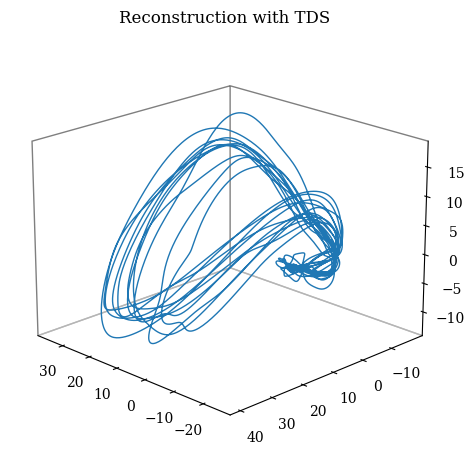

In [18]:
shape_dims = [6, 3]
S = np.array([
    delay_embedding_matrix(x_ssa, shape_dims[0]*50)[:,::20],
    delay_embedding_matrix(y_ssa, shape_dims[0]*50)[:,::20],
    delay_embedding_matrix(z_ssa, shape_dims[0]*50)[:,::20]
])
################################################
## Make a subspace #############################
X_p = []
for i in range(S.shape[1]):
    X_p.append(tl.tenalg.outer([S[n,i,:] for n in range(S.shape[0])]).reshape(-1,))
    
X_p = np.array(X_p)
visuals.plot_phase_trajectory(
    PCA(3).fit_transform(X_p)[:],
    path=f'./figs/tds_{path_basic_experiment[index_activity]}.png',
    rotation = (0,-60,0),
    title = "Reconstruction with TDS"
) 